# Hypothesis testing on demographical features

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


Importing the specifically created files for cleaning and merging

In [3]:
import datamerge



### Retrieving data for the project


In [4]:
#creating dataframe from csv files
offender_df = pd.read_csv('data/offender_race_state.csv')
employment_df = pd.read_csv('data/employment_state.csv')
victim_df = pd.read_csv('data/victim_tkm_state.csv')
race_ratio_df = pd.read_excel('data/Population_byrace_bystate.xlsx')

The source of the ethnicity data: 2017 1-year American Community Survey estimates, U.S. Census Bureau, retrieved from: https://www.governing.com/gov-data/census/state-minority-population-data-estimates.html

In [5]:
#creating a population table
population_df = datamerge.create_population_df(employment_df, race_ratio_df)

In [6]:
population_df.head(2)
offender_df.head(2)

,state,year,race,offense,offenders
0,AL,2010,Asian,aggravated-assault,0
1,AL,2011,Asian,aggravated-assault,0


In [7]:
#table for visualisation
table = offender_df.loc[offender_df.year == 2018].groupby('race').offenders.sum().reset_index()
table

,race,offenders
0,American Indian or Alaska Native,44984
1,Asian,31612
2,Black or African American,1162774
3,Native Hawaiian,0
4,Unknown,1168656
5,White,2013720


In [8]:
offender_df = datamerge.create_offender_df(offender_df, population_df)

/Users/flatironschool/fis/Projects/mod3project/stats_project2/datamerge.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_black['black_pop'] = df_black['black'] * df_black['population']
/Users/flatironschool/fis/Projects/mod3project/stats_project2/datamerge.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_black['black_norm'] = df_black.offenders / df_black.black_pop * 1000
/Users/flatironschool/fis/Projects/mod3project/stats_project2/datamerge.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [9]:
offender_df.head(6)

,state,year,white_norm,black_norm
0,AL,2010,0.416670,1.158145
1,AL,2011,0.441337,1.014235
2,AL,2012,0.498975,1.193089
3,AL,2013,0.470682,1.341704
4,AL,2014,0.520664,1.308098
5,AL,2015,0.586534,1.188836


# I. Testing offender ratio by races




Offender ratio for a race means the normalized ratio according its own population 

      calculation: number of offenders / (population number * race ratio) * 1000


and so the calculated number shows that among its own population how many offender was identified from 1000 people.


## Visualization

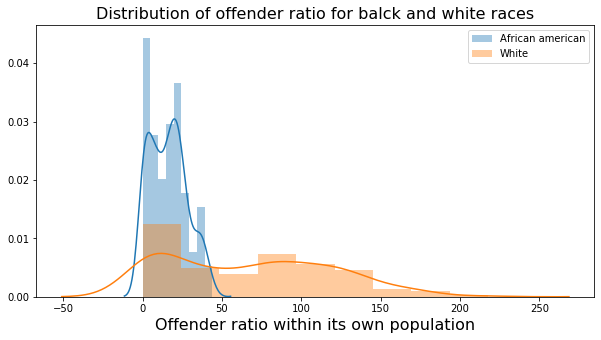

In [10]:
plt.figure(figsize = (10,5))
sns.distplot(offender_df.white_norm, label = 'African american')
sns.distplot(offender_df.black_norm, label = 'White')
plt.xlabel('Offender ratio within its own population', fontsize=16)
plt.title('Distribution of offender ratio for balck and white races', fontsize=16)
plt.legend();

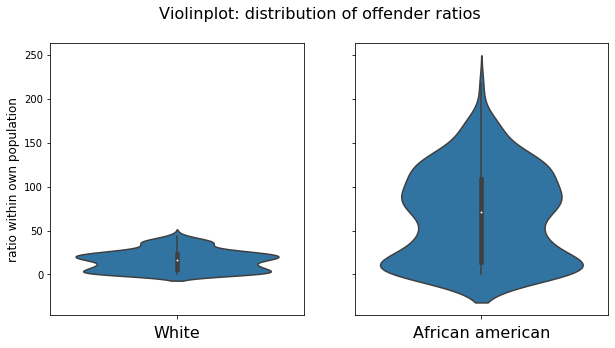

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5), sharey=True)

fig.suptitle('Violinplot: distribution of offender ratios', fontsize=16)
sns.violinplot(y=offender_df.white_norm, ax=ax1)
ax1.set_xlabel('White', fontsize=16)
ax1.set_ylabel('ratio within own population', fontsize=12)
sns.violinplot(y=offender_df.black_norm, ax=ax2)
ax2.set_xlabel('African american', fontsize = 16)
ax2.set_ylabel('');

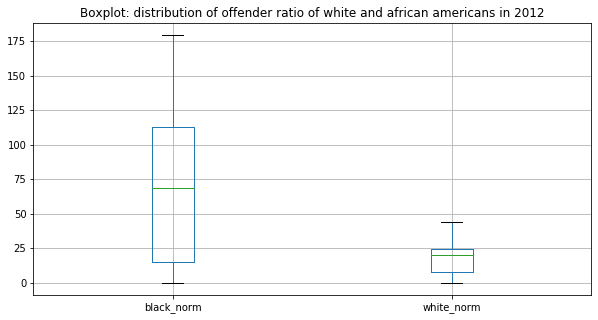

In [12]:
plt.figure(figsize=(10,5))

offender_2012 = offender_df.loc[offender_df.year == 2012]

offender_2012.boxplot(column = ['black_norm', 'white_norm'])
plt.title('Boxplot: distribution of offender ratio of white and african americans in 2012', fontsize=12);

In [13]:
print(f'''The average ratio among african americans is {offender_df.black_norm.mean():.2f}, and among white people is {offender_df.white_norm.mean():.2f}.''')

The average ratio among african americans is 67.48, and among white people is 16.20.


### Paired sample T-test

According to the visualization we can detect remarkable differences in ratios. We will compare differences of black and white offenders by every state and year. We would like to know, whether the difference we can see on visualizasion is really significant.

Null hypothesis: there is no difference of mean of offender ratios between these races

       H_null: B_mean - W_mean = 0

Alternative hypothesis: the ratio of offenders are higher among African american people

       H_alternative: B_mean - W_mean > 0

==> Right tailed test

Significance level: 5%

In [14]:
offender_df['difference'] = offender_df.black_norm - offender_df.white_norm

In [15]:
offender_df.head(3)

,state,year,white_norm,black_norm,difference
0,AL,2010,0.416670,1.158145,0.741475
1,AL,2011,0.441337,1.014235,0.572898
2,AL,2012,0.498975,1.193089,0.694114


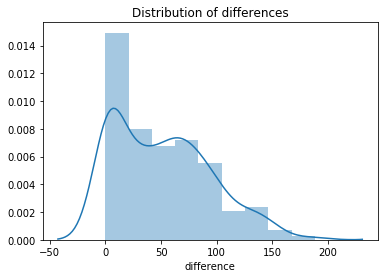

In [16]:
sns.distplot(offender_df.difference)
plt.title('Distribution of differences');

In [17]:
stat, p_value = stats.normaltest(offender_df.difference)

In [18]:
print(f'Normaltest statistic: {stat:.3f}, p_value: {p_value:.3f}.')

Normaltest statistic: 21.662, p_value: 0.000.


According to the normaltest the differences are not normally distributed at 5% significance level, this violates the assumption of the paired sample T-test.

### Calculation of the test statistic

In [19]:
mean = offender_df['difference'].mean()
n = len(offender_df)
std = np.array(offender_df['difference']).std(ddof=1)

t = mean/(std/n**0.5)
p_value = stats.t.sf(t, df=n-1)

In [20]:
print(f'T-statistic: {t:.3f}, p_value: {p_value:.3f}')

T-statistic: 22.097, p_value: 0.000


### Conclusion

Given the evidences, at 5% significance level we can reject the null hypothesis, the difference of offender ratios between white and africane americans are significant.

# II. Genders in crimes

### Retrieving data

In [21]:
victims_df = datamerge.create_victim_df(victim_df, population_df)

/Users/flatironschool/fis/Projects/mod3project/stats_project2/datamerge.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df4['male_proportion'] = df4.count_male / (df4.count_male + df4.count_female)


In [22]:
victims_df.head()

,state,year,count_male,count_female,population,male_proportion
0,AL,2010,1510,1482,4792630,0.504679
1,AL,2011,1556,1498,4815348,0.509496
2,AL,2012,1582,1598,4834334,0.497484
3,AL,2013,1716,1610,4845981,0.515935
4,AL,2014,1544,1240,4861676,0.554598


### Visualization

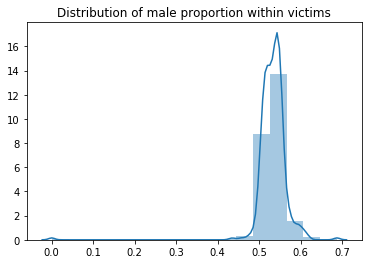

In [23]:
sns.distplot(victims_df.male_proportion, bins = 17, norm_hist = True)
plt.title('Distribution of male proportion within victims', fontsize=12)
plt.xlabel('');

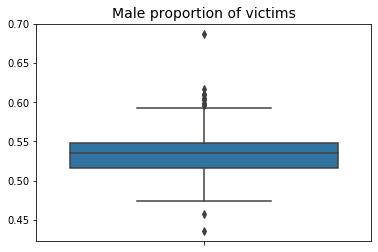

In [24]:
sns.boxplot(y = victims_df.loc[victims_df.male_proportion>0.4].male_proportion)
plt.title('Male proportion of victims', fontsize = 14)
plt.ylabel('');


In [25]:
print(f'The average proportion of male victims is {victims_df.male_proportion.mean():.2f}.')

The average proportion of male victims is 0.53.


### Large sample test for proportion: Z-test 

According to the visualization we can see that the proportion of the male victims are over 50%. We will test whether this proportion is significantly higher than 50%.

Null hypothesis: the proportion of male victims is 50%.

        H_null: p = 0.5
        
      
Alternative hypothesis: the proportion of male victims is higher than 50%.

        H_alternative: p > 0.5


Where p denotes the population proportion.


==> Right-tailed test

Significance level: 5%


### Calculation of test statistic

In [26]:
n = len(victims_df)
p_mean = victims_df.male_proportion.mean()

z_statistic = (p_mean - 0.5) / (0.5 * 0.5 / n )**0.5
p_value = stats.norm.sf(z_statistic)

In [32]:
print(f'Number of observations: {n}')
print(f'Standard error: {(0.5 * 0.5 / n )**0.5:.3f}')
print(f'Z-statistic: {z_statistic:.3f}, p_value: {p_value:.3f}')

Number of observations: 346
Standard error: 0.027
Z-statistic: 1.233, p_value: 0.109


Checking the assumption of the large sample size:

1.) the calculated values should lie within the range of 0 and 1.

In [28]:
p_mean - 3 * (p_mean*(1-p_mean)/n)**0.5

0.45267960677383534

In [29]:
p_mean + 3 * (p_mean*(1-p_mean)/n)**0.5

0.6136059002105826

2.) The data are an SRS from the population of interest.

3.) The population is at least 10 times as large as the sample

4.) For a test of H_null, n*p > 10 and n*(1-p) > 10

### Conclusion

There is not enough evidences at 5% significance level to reject the null hypothesis, the male proportion of the victimes are not significantly higher than 50%.